In [56]:
%matplotlib inline
import IPython
import matplotlib
import os
import matplotlib.pyplot as plt
from PIL import Image
from scipy.spatial.distance import cdist
import numpy as np
import cv2
%pdb
from ipywidgets import interact, fixed, FloatSlider, IntSlider, Checkbox, FloatRangeSlider

Automatic pdb calling has been turned OFF


In [57]:
train_weights = {}
test_weights = {}
train_eigen_face_vec = {}
eigen_vec_error_dict = {}

In [58]:
def load_images(path):
	file_dic = {}
	sub_directory = []
	image_list = []
	id_list = []
	for subdir, dirs, files in os.walk(path):
		for file in files:
			split_list = file.split("_")
			id = split_list[0]
			id_list.append(id)
			if file.find("jpg") > -1:
				if subdir in file_dic:
					file_dic[subdir].append(os.path.join(subdir, file))
					image = (cv2.imread(os.path.join(subdir, file), 0)) / 255.
					image_list.append(image)
				else:
					sub_directory.append(subdir)
					file_dic[subdir] = [os.path.join(subdir, file)]
					image = (cv2.imread(os.path.join(subdir, file), 0)) / 255.
					image_list.append(image)
	return image_list, file_dic, sub_directory, id_list

In [59]:
def display_images(image_list, title):
	fig1, axes_array = plt.subplots(5, 5)
	fig1.set_size_inches(5, 5)
	i = 0
	for row in range(0, 5):
		for col in range(0, 5):
			image = cv2.resize(image_list[i], (100, 100))
			axes_array[row, col].imshow(image, cmap=plt.cm.gray)
			axes_array[row, col].axis('off')
			i += 1
	plt.suptitle(title)
	plt.show()

In [60]:
def calculate_covariance(matrix):
	return np.cov(matrix, rowvar=False)

In [61]:
def calculate_image_vector_matrix(image_list):
	# =============================================================
	#               calculating FACE VECTOR
	# =============================================================
	val_1, val_2 = image_list[0].shape
	rows = val_1 * val_2
	image_vec_matrix = np.zeros((rows, len(image_list)))
	i = 0
	for image in image_list:
		vector = image.flatten()
		vector = np.asmatrix(vector)
		image_vec_matrix[:, i] = vector
		i += 1
	return image_vec_matrix

In [62]:
def calculate_mean_face(image_vec_matrix):
	# =============================================================
	#              calculating MEAN FACE VECTOR
	# =============================================================
	mean_face_vec = np.mean(image_vec_matrix, axis=1)
	mean_face_vec = np.asmatrix(mean_face_vec)
	
	# =============================================================
	#               calculating MEAN FACE IMAGE
	# =============================================================
	mean_face_img = np.reshape(mean_face_vec, (size, size))
	plt.imshow(cv2.resize(mean_face_img, (100, 100)), cmap='gray')
	plt.suptitle("Mean Face Image")
	plt.show()
	
	return mean_face_vec

In [63]:
def store_weights(k, zero_mean_face_matrix):
	k_eigen_faces_vec = train_eigen_face_vec[k]
	# =============================================================
	#          				Calculate WEIGHTS
	# =============================================================
	k_weights = np.dot(k_eigen_faces_vec, zero_mean_face_matrix)
	k_weights = np.transpose(k_weights)
	test_weights[k] = k_weights

In [64]:
def reconstruct(k, eig_vec, zero_mean_face_matrix, mean_face_vec):
	k_faces = []
	# =============================================================
	#              Pick first K EIGEN VECTOR
	# =============================================================
	k_eig_vec = eig_vec[0: k, :]
	
	# =============================================================
	#          Calculate EIGEN FACES from K EIGEN VECTOR
	# =============================================================
	k_eigen_faces_vec = np.dot(zero_mean_face_matrix, k_eig_vec.T)
	k_eigen_faces_vec = np.transpose(k_eigen_faces_vec)
	train_eigen_face_vec[k] = k_eigen_faces_vec
	# =============================================================
	#          				Calculate WEIGHTS
	# =============================================================
	k_weights = np.dot(k_eigen_faces_vec, zero_mean_face_matrix)
	k_weights = np.transpose(k_weights)
	train_weights[k] = k_weights

	# ==============================================================
	#          		       Perform Reconstruction
	# ===========q==================================================
	if k == 2 or k == 5 or k == 15:
		k_reconstruction = mean_face_vec + np.dot(k_weights, k_eigen_faces_vec)
		k_reconstruction = np.transpose(k_reconstruction)
		
		for face in range(0, k_reconstruction.shape[1]):
			k_faces.append(np.reshape(k_reconstruction[:, face], (size, size)))
		
		# =============================================================
		#          		       Display Eigen FACES
		# =============================================================
		display_images(k_faces, "Reconstructed Images with " + str(k) + " eigen vectors")

In [65]:
def get_zero_mean_face_matrix(image_vec_matrix, mean_face_vec):
	# =============================================================
	#      calculating zero_mean_face_matrix and Covariance
	# =============================================================
	zero_mean_face_matrix = []
	count = 0
	loop_end = np.shape(image_vec_matrix)[1]
	for i in range(loop_end):
		image_col_vector = image_vec_matrix[:, i]
		image_col_vector = image_col_vector - mean_face_vec
		
		if count == 0:
			zero_mean_face_matrix = image_col_vector
			count += 1
		else:
			zero_mean_face_matrix = np.vstack((zero_mean_face_matrix, image_col_vector))
		
	zero_mean_face_matrix = zero_mean_face_matrix.T
	return zero_mean_face_matrix

In [66]:
def euclidean(test_weight, training_weights, train_images, test_img, k, l, acc, thr):
	# =============================================================
	#              calculating Euclidean Distance
	# =============================================================
	dist = []
	for weight in range(0, training_weights.shape[0]):
		dist.append(cdist(np.asmatrix(test_weight), np.asmatrix(training_weights[weight, :]), 'euclidean'))
	closest = dist.index(min(dist))
	# =============================================================
	#                   Performing Classification
	# =============================================================
	if min(dist) > thr and thr !=0 :
		if test_id_list[l] == "S099" or train_id_list[l] not in train_id_list:
			acc += 1
		if k == 2 or k == 5 or k == 15:
			print("Eigen_Vectors Used are %d"%(k),"distance calculated is %d"% (min(dist)))
			fig1, axes_array = plt.subplots(1, 2)
			fig1.set_size_inches(5, 5)
			axes_array[0].imshow(test_img, cmap=plt.cm.gray)
			axes_array[0].axis('off')
			axes_array[0].title.set_text('Test_Image')
			axes_array[1].imshow(np.zeros((425, 425)), cmap=plt.cm.gray)
			axes_array[1].axis('off')
			axes_array[1].title.set_text('Non-Face or Uknown')
            
	elif test_id_list[l] == train_id_list[closest]:
		acc += 1
		
		if k == 2 or k == 5 or k == 15:
			print("Eigen_Vectors Used are %d"%(k),"distance calculated is %d"% (min(dist)))
			fig1, axes_array = plt.subplots(1, 2)
			fig1.set_size_inches(5, 5)
			axes_array[0].imshow(test_img, cmap=plt.cm.gray)
			axes_array[0].axis('off')
			axes_array[0].title.set_text('Test_Image')
			axes_array[1].imshow(train_images[closest], cmap=plt.cm.gray)
			axes_array[1].axis('off')
			axes_array[1].title.set_text('Classified_Image')

	elif test_id_list[l] != train_id_list[closest]:
		if k == 2 or k == 5 or k == 15: 
			print("Eigen_Vectors Used are %d"%(k),"distance calculated is %d"% (min(dist)))
			fig1, axes_array = plt.subplots(1, 2)
			fig1.set_size_inches(5, 5)
			axes_array[0].imshow(test_img, cmap=plt.cm.gray)
			axes_array[0].axis('off')
			axes_array[0].title.set_text('Test_Image')
			axes_array[1].imshow(train_images[closest], cmap=plt.cm.gray)
			axes_array[1].axis('off')
			axes_array[1].title.set_text('Classified_Image')
	plt.show()
	return acc

In [67]:
def get_eig_vectors(zero_mean_face_matrix, mean_face_vec):
	# zero_mean_face_matrix = image_vec_matrix - mean_face_vec
	covariance = calculate_covariance(zero_mean_face_matrix)
	# =============================================================
	#      			   calculating Eigen Faces
	# =============================================================
	eig_values, eig_vectors = np.linalg.eig(covariance)
	eig_faces_vec = np.dot(zero_mean_face_matrix, eig_vectors)
	eig_face = []
	for face in range(0, eig_faces_vec.shape[1]):
		eig_face.append(np.reshape(eig_faces_vec[:, face], (size, size)))
	
	# =============================================================
	#      			   Displaying Eigen Faces
	# =============================================================
	display_images(eig_face, "Eigen Faces")
	
	# =============================================================
	#      				Sorting Eigen Values
	# =============================================================
	eig_values, eig_vectors = zip(*sorted(zip(eig_values, eig_vectors)))
	eig_values = np.asarray(list(eig_values[::-1]))
	eig_vectors = np.asarray(list(eig_vectors[::-1]))
	return eig_vectors


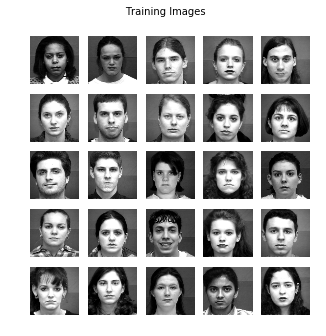

In [68]:
size = 425
# =============================================================
#      						Training
# =============================================================
train_path = "C:\\Users\\jaysh\\Desktop\\Eigen Face\\Eigenfaces\\Train"
train_img_list, train_file_dict, train_sub_dir, train_id_list = load_images(train_path)
display_images(train_img_list, "Training Images")


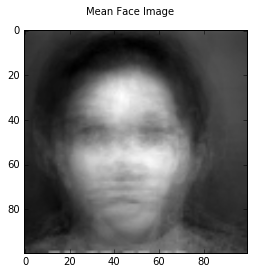

In [69]:
train_image_vector_matrix = calculate_image_vector_matrix(train_img_list)
train_mean_face_vector = calculate_mean_face(train_image_vector_matrix)
train_zero_mean_face_matrix = get_zero_mean_face_matrix(train_image_vector_matrix, train_mean_face_vector)

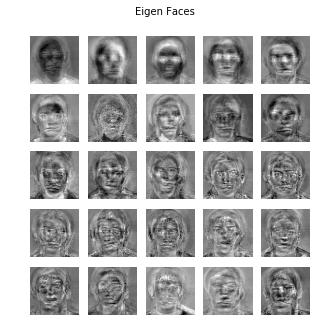

In [70]:
eig_vectors = get_eig_vectors(train_zero_mean_face_matrix, train_mean_face_vector)

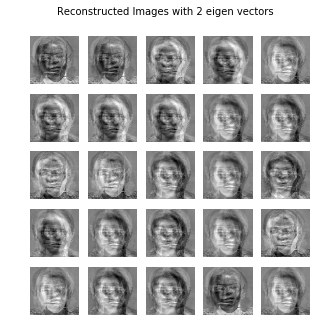

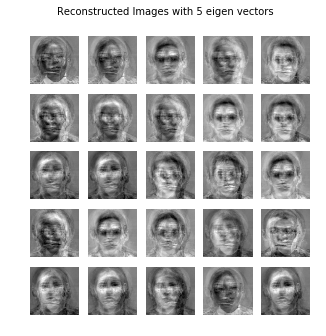

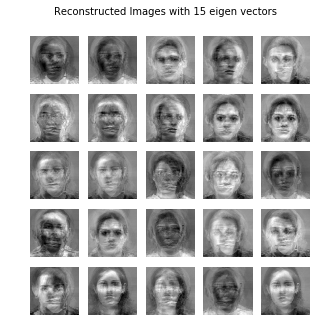

In [71]:
	for i in range(len(train_img_list)):
		reconstruct(i+1, eig_vectors, train_zero_mean_face_matrix, train_mean_face_vector)

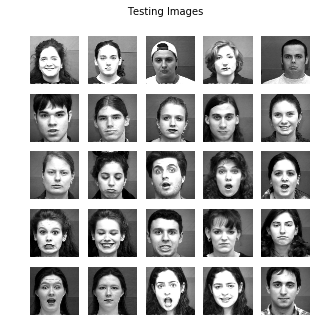

In [72]:
# =============================================================
#      						Testing
# =============================================================
test_path = "C:\\Users\\jaysh\\Desktop\\Eigen Face\\Eigenfaces\\Test"
test_img_list, test_file_dict, test_sub_dir, test_id_list = load_images(test_path)
display_images(test_img_list, "Testing Images")
test_image_vector_matrix = calculate_image_vector_matrix(test_img_list)
test_zero_mean_face_matrix = get_zero_mean_face_matrix(test_image_vector_matrix, train_mean_face_vector)
for i in range(0, len(train_img_list)):
	store_weights(i+1, test_zero_mean_face_matrix)

Eigen_Vectors Used are 2 distance calculated is 262


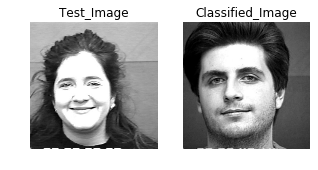

Eigen_Vectors Used are 2 distance calculated is 1128


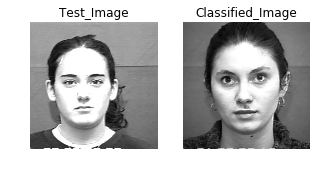

Eigen_Vectors Used are 2 distance calculated is 1719


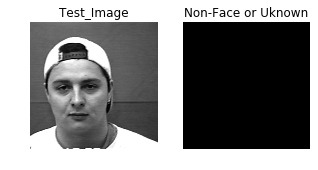

Eigen_Vectors Used are 2 distance calculated is 31


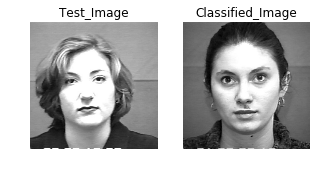

Eigen_Vectors Used are 2 distance calculated is 2458


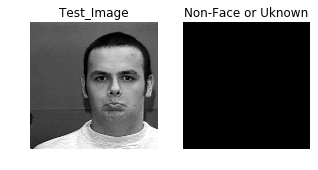

Eigen_Vectors Used are 2 distance calculated is 706


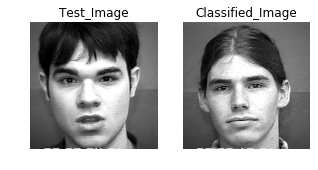

Eigen_Vectors Used are 2 distance calculated is 56


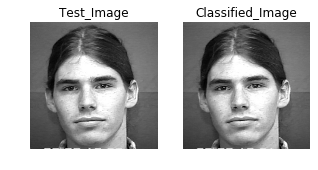

Eigen_Vectors Used are 2 distance calculated is 637


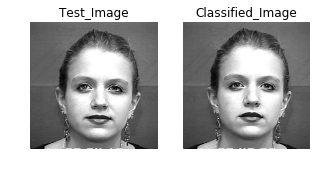

Eigen_Vectors Used are 2 distance calculated is 4


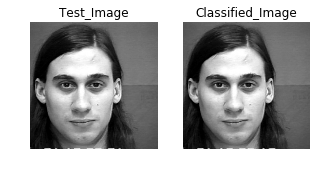

Eigen_Vectors Used are 2 distance calculated is 217


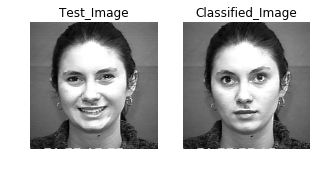

Eigen_Vectors Used are 2 distance calculated is 334


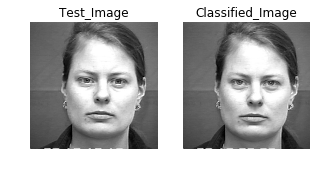

Eigen_Vectors Used are 2 distance calculated is 108


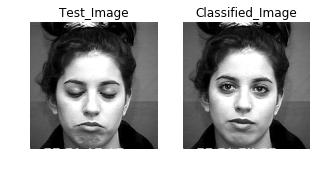

Eigen_Vectors Used are 2 distance calculated is 1259


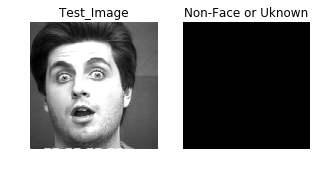

Eigen_Vectors Used are 2 distance calculated is 130


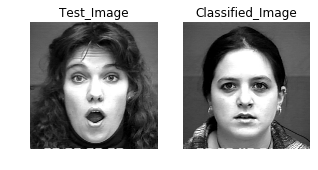

Eigen_Vectors Used are 2 distance calculated is 739


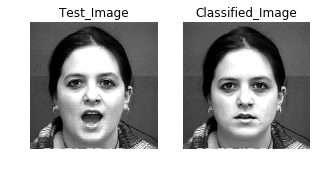

Eigen_Vectors Used are 2 distance calculated is 264


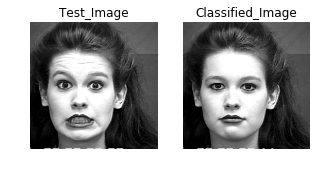

Eigen_Vectors Used are 2 distance calculated is 598


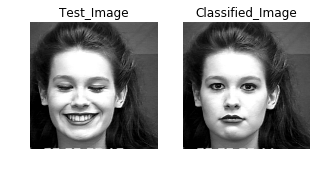

Eigen_Vectors Used are 2 distance calculated is 982


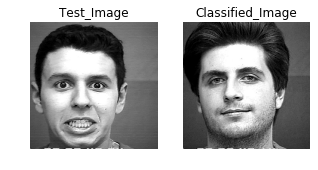

Eigen_Vectors Used are 2 distance calculated is 95


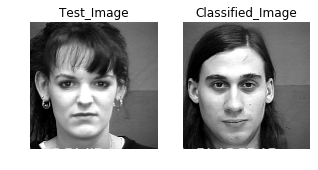

Eigen_Vectors Used are 2 distance calculated is 510


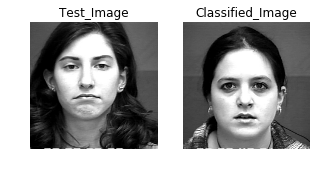

Eigen_Vectors Used are 2 distance calculated is 285


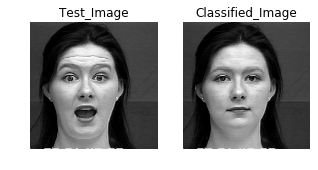

Eigen_Vectors Used are 2 distance calculated is 685


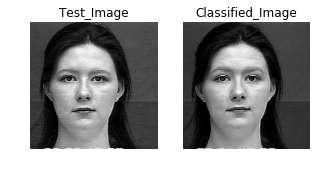

Eigen_Vectors Used are 2 distance calculated is 680


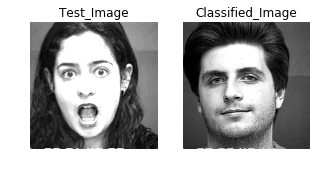

Eigen_Vectors Used are 2 distance calculated is 605


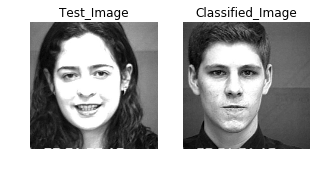

Eigen_Vectors Used are 2 distance calculated is 714


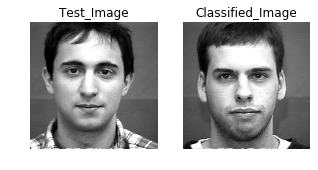

Eigen_Vectors Used are 2 distance calculated is 2765


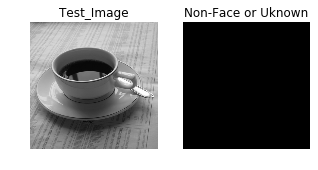

Eigen_Vectors Used are 2 distance calculated is 1480


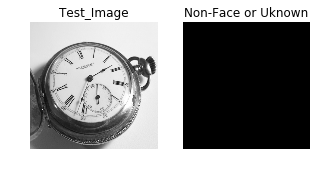

Eigen_Vectors Used are 2 distance calculated is 449


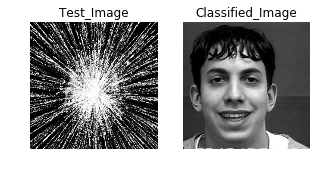

Eigen_Vectors Used are 2 distance calculated is 2036


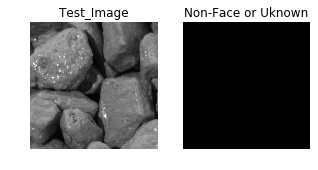

Eigen_Vectors Used are 2 distance calculated is 1328


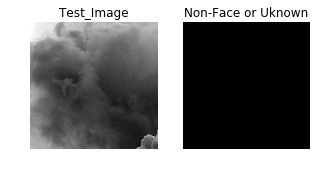

Eigen_Vectors Used are 2 distance calculated is 696


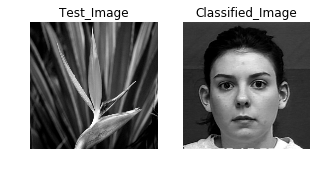

Eigen_Vectors Used are 2 distance calculated is 338


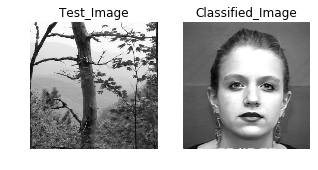

Eigen_Vectors Used are 5 distance calculated is 2182


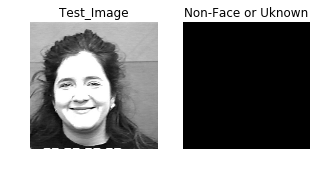

Eigen_Vectors Used are 5 distance calculated is 2764


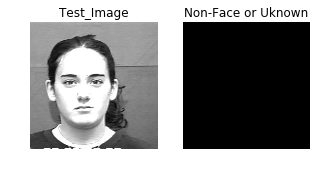

Eigen_Vectors Used are 5 distance calculated is 2859


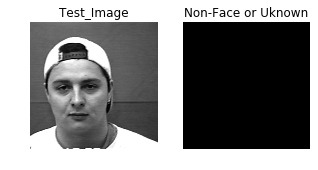

Eigen_Vectors Used are 5 distance calculated is 2175


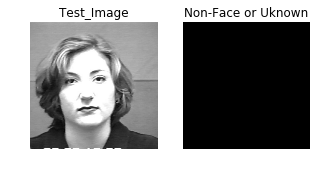

Eigen_Vectors Used are 5 distance calculated is 3361


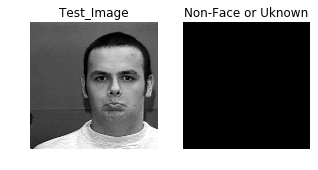

Eigen_Vectors Used are 5 distance calculated is 2700


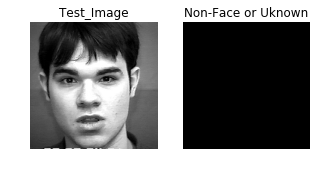

Eigen_Vectors Used are 5 distance calculated is 78


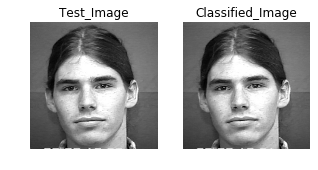

Eigen_Vectors Used are 5 distance calculated is 873


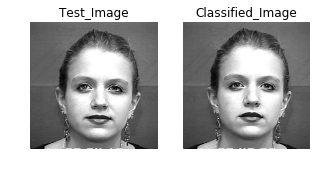

Eigen_Vectors Used are 5 distance calculated is 66


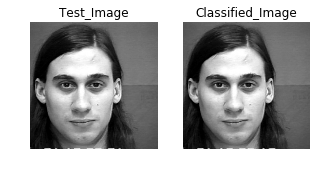

Eigen_Vectors Used are 5 distance calculated is 828


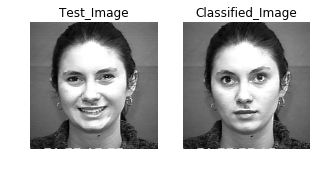

Eigen_Vectors Used are 5 distance calculated is 700


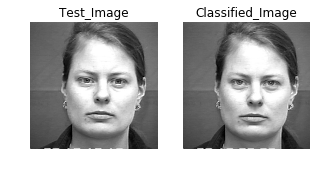

Eigen_Vectors Used are 5 distance calculated is 415


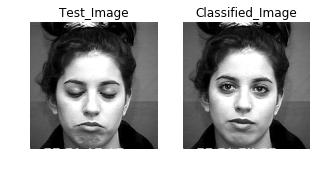

Eigen_Vectors Used are 5 distance calculated is 1718


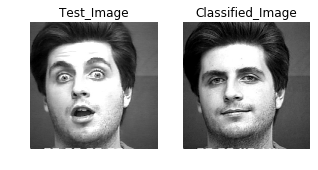

Eigen_Vectors Used are 5 distance calculated is 857


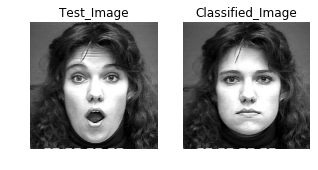

Eigen_Vectors Used are 5 distance calculated is 1834


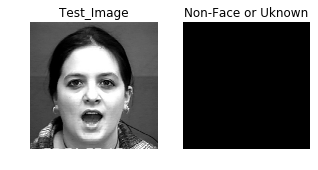

Eigen_Vectors Used are 5 distance calculated is 352


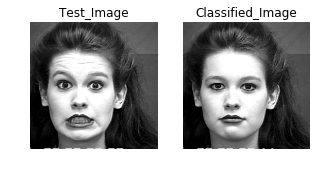

Eigen_Vectors Used are 5 distance calculated is 925


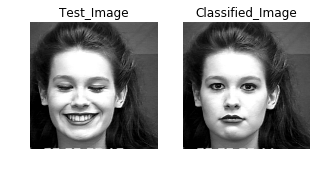

Eigen_Vectors Used are 5 distance calculated is 2001


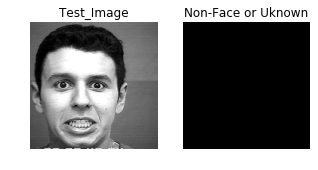

Eigen_Vectors Used are 5 distance calculated is 1272


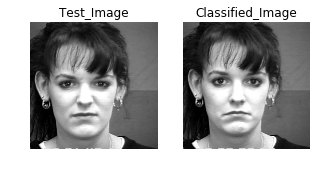

Eigen_Vectors Used are 5 distance calculated is 734


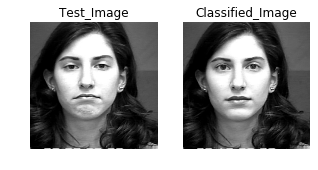

Eigen_Vectors Used are 5 distance calculated is 388


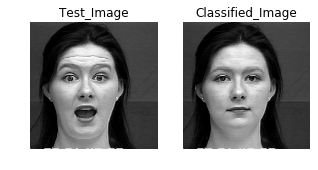

Eigen_Vectors Used are 5 distance calculated is 852


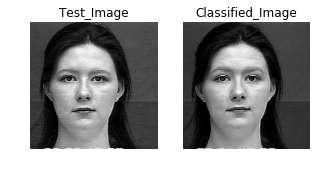

Eigen_Vectors Used are 5 distance calculated is 3256


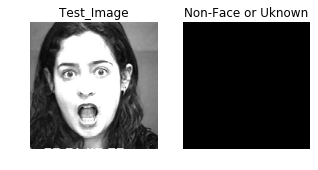

Eigen_Vectors Used are 5 distance calculated is 2812


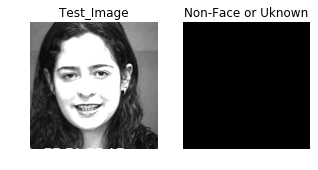

Eigen_Vectors Used are 5 distance calculated is 2283


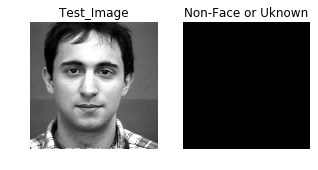

Eigen_Vectors Used are 5 distance calculated is 3772


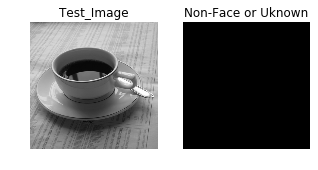

Eigen_Vectors Used are 5 distance calculated is 3142


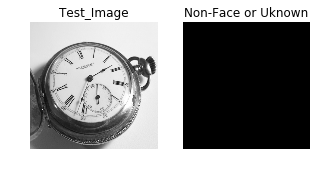

Eigen_Vectors Used are 5 distance calculated is 2443


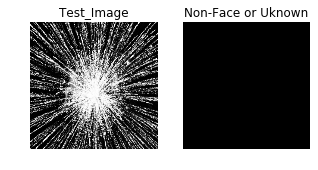

Eigen_Vectors Used are 5 distance calculated is 2298


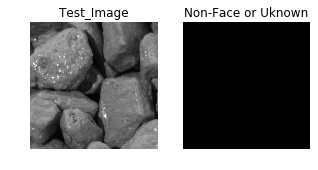

Eigen_Vectors Used are 5 distance calculated is 2791


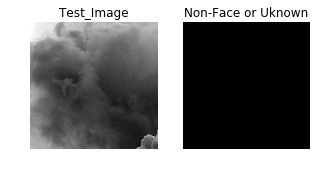

Eigen_Vectors Used are 5 distance calculated is 2996


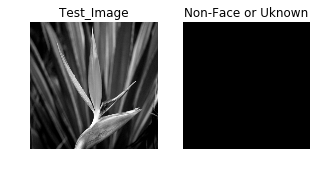

Eigen_Vectors Used are 5 distance calculated is 2881


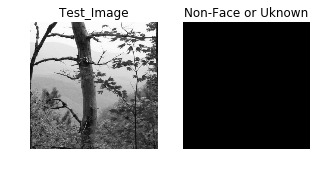

Eigen_Vectors Used are 15 distance calculated is 6110


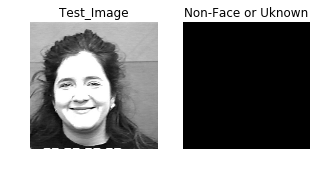

Eigen_Vectors Used are 15 distance calculated is 4921


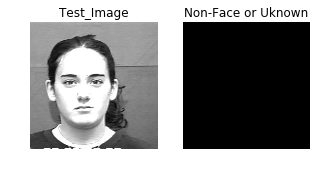

Eigen_Vectors Used are 15 distance calculated is 6058


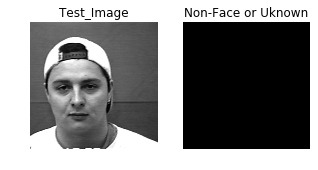

Eigen_Vectors Used are 15 distance calculated is 6903


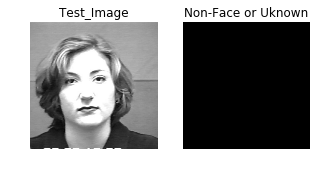

Eigen_Vectors Used are 15 distance calculated is 6597


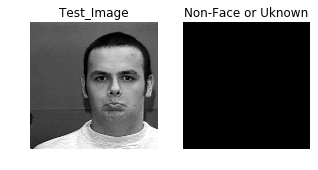

Eigen_Vectors Used are 15 distance calculated is 4530


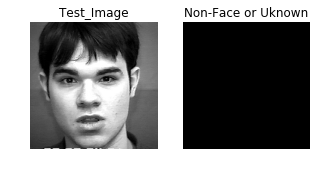

Eigen_Vectors Used are 15 distance calculated is 160


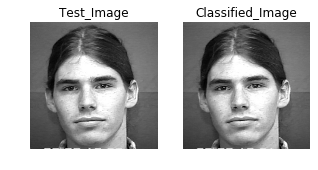

Eigen_Vectors Used are 15 distance calculated is 1182


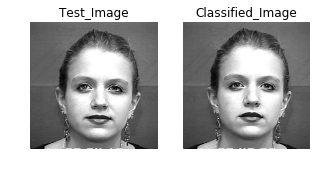

Eigen_Vectors Used are 15 distance calculated is 85


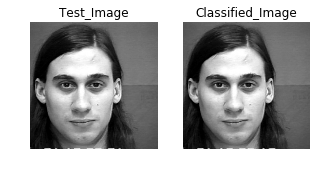

Eigen_Vectors Used are 15 distance calculated is 1189


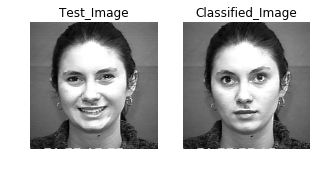

Eigen_Vectors Used are 15 distance calculated is 1000


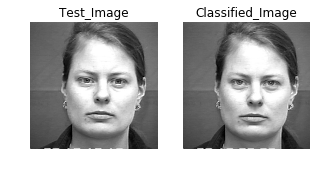

Eigen_Vectors Used are 15 distance calculated is 1225


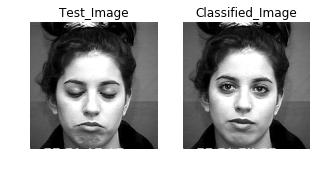

Eigen_Vectors Used are 15 distance calculated is 3419


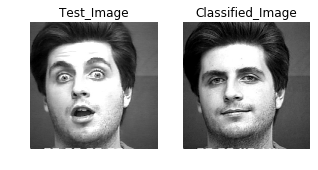

Eigen_Vectors Used are 15 distance calculated is 1728


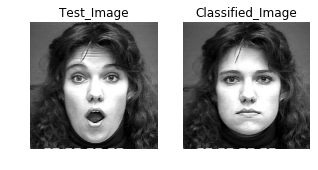

Eigen_Vectors Used are 15 distance calculated is 2702


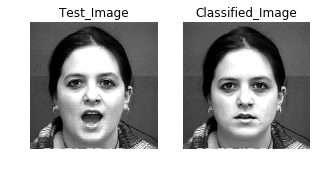

Eigen_Vectors Used are 15 distance calculated is 701


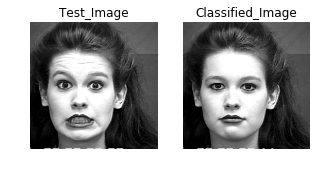

Eigen_Vectors Used are 15 distance calculated is 1204


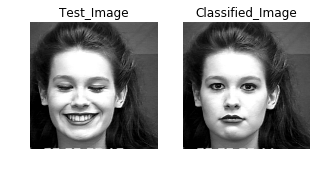

Eigen_Vectors Used are 15 distance calculated is 2574


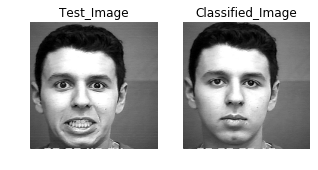

Eigen_Vectors Used are 15 distance calculated is 1842


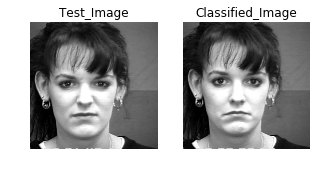

Eigen_Vectors Used are 15 distance calculated is 1069


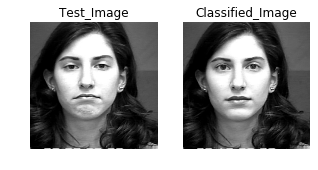

Eigen_Vectors Used are 15 distance calculated is 703


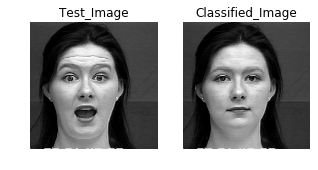

Eigen_Vectors Used are 15 distance calculated is 1462


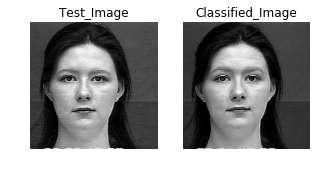

Eigen_Vectors Used are 15 distance calculated is 5750


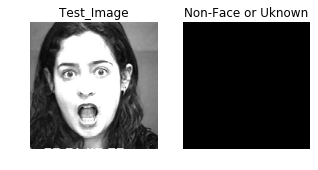

Eigen_Vectors Used are 15 distance calculated is 4669


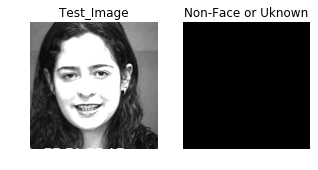

Eigen_Vectors Used are 15 distance calculated is 5145


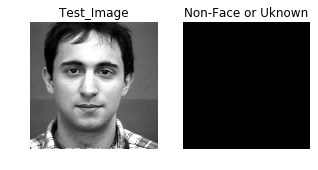

Eigen_Vectors Used are 15 distance calculated is 7757


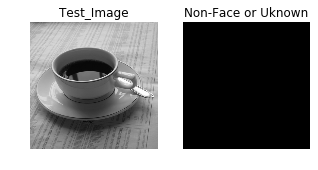

Eigen_Vectors Used are 15 distance calculated is 7178


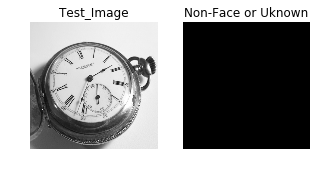

Eigen_Vectors Used are 15 distance calculated is 4809


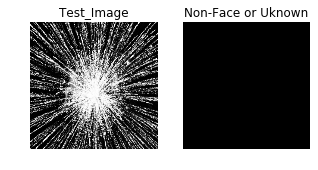

Eigen_Vectors Used are 15 distance calculated is 5600


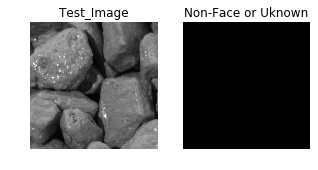

Eigen_Vectors Used are 15 distance calculated is 7579


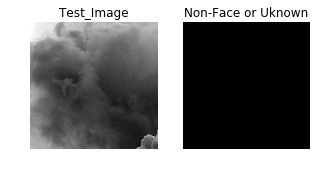

Eigen_Vectors Used are 15 distance calculated is 6602


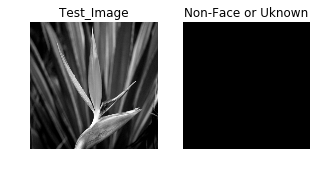

Eigen_Vectors Used are 15 distance calculated is 4872


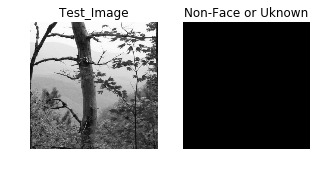

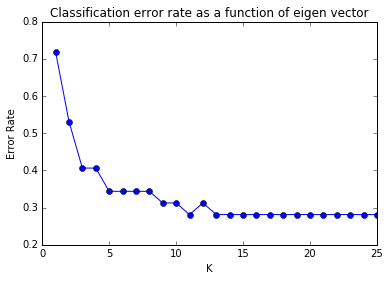

In [75]:
# =============================================================
#      						Task 3
# =============================================================

def classifying(thr = 0):
	error_rate = []
	k_eigen = []
	for i in range(0, len(train_img_list)):
		acc = 0
		for j in range(0, len(test_img_list)):
			acc = euclidean(test_weights[i+1][j, :], train_weights[i+1], train_img_list, test_img_list[j], i+1, j, acc, thr) 
		if thr != 0 : 
			thr += 200
		acc /= len(test_img_list)
		eigen_vec_error_dict[i + 1] = 1 - acc
		k_eigen.append(i + 1)
		error_rate.append(1 - acc)
	plt.plot(k_eigen, error_rate, marker = 'o')
	plt.xlabel('K')
	plt.ylabel('Error Rate')
	plt.title('Classification error rate as a function of eigen vector')
	plt.show()
temp=interact(classifying,thr = IntSlider(min=0, max=5000, step=500, value=1000, continuous_update=False));